Red units: total time: 9.174311926605505, timestep: 0.0004587155963302752, Steps: 20000
Block sizes for V: [  10   20   40   80  160  320  640 1280 2560 5120]
Block sizes for K: [  10   20   40   80  160  320  640 1280 2560 5120]
Block sizes for T: [  10   20   40   80  160  320  640 1280 2560 5120]
Average Potential Energy (V): (-1.1770±0.0014)×10⁻¹⁸ J
Average Kinetic Energy (K): (2.472±0.014)×10⁻¹⁹ J
Average Temperature (T): 95.49±0.52 K
Chosen Block Size: 320
Average Potential Energy (V): -1.1770443355850512e-18 J
Average Kinetic Energy (K): 2.4719087871713107e-19 J
Average Temperature (T): 95.48779980704961 K
Specific Heat Capacity (c_V): 19.467821594122494 J/K/mol


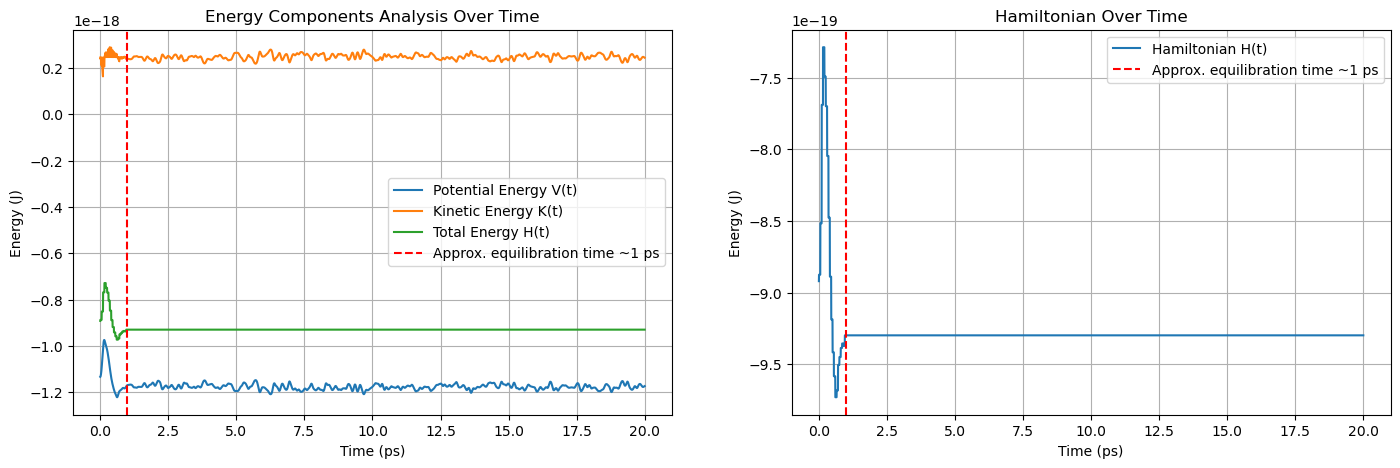

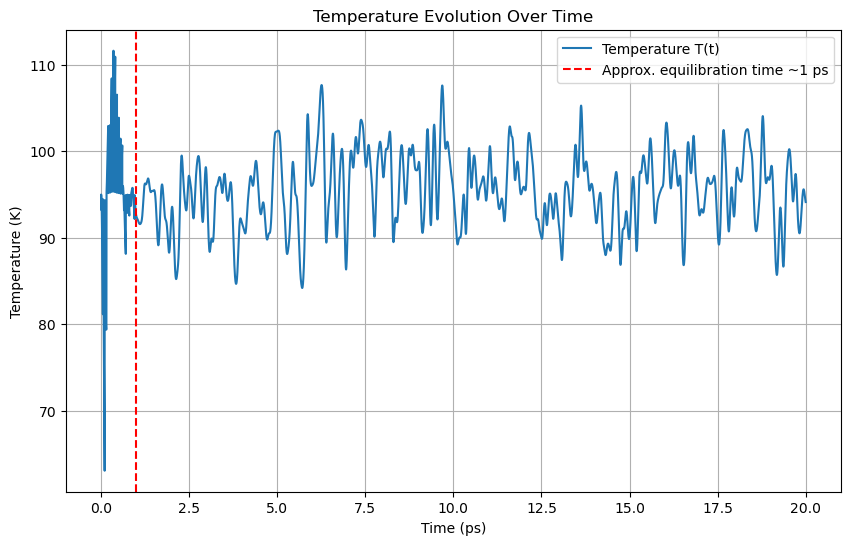

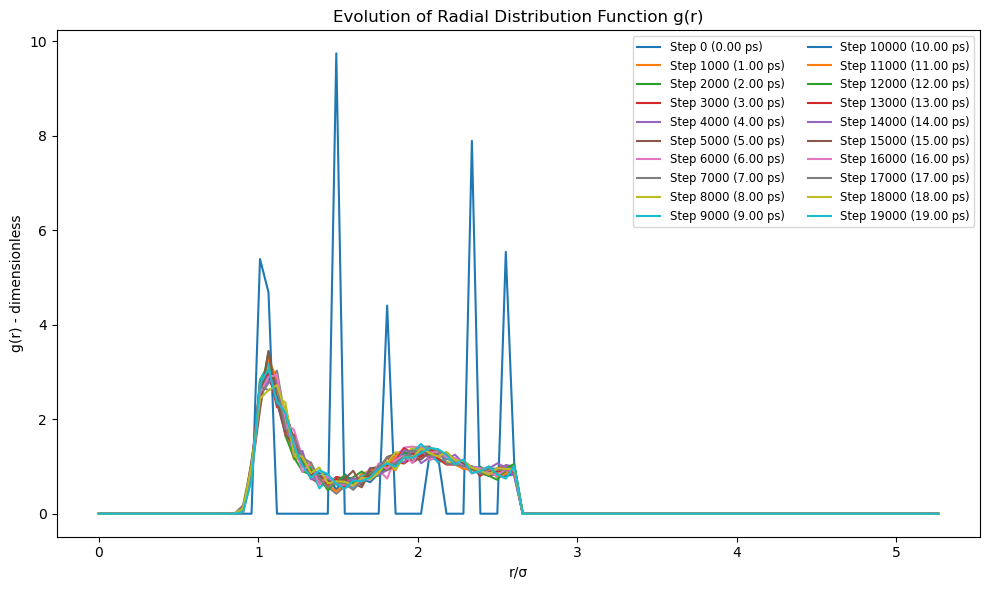

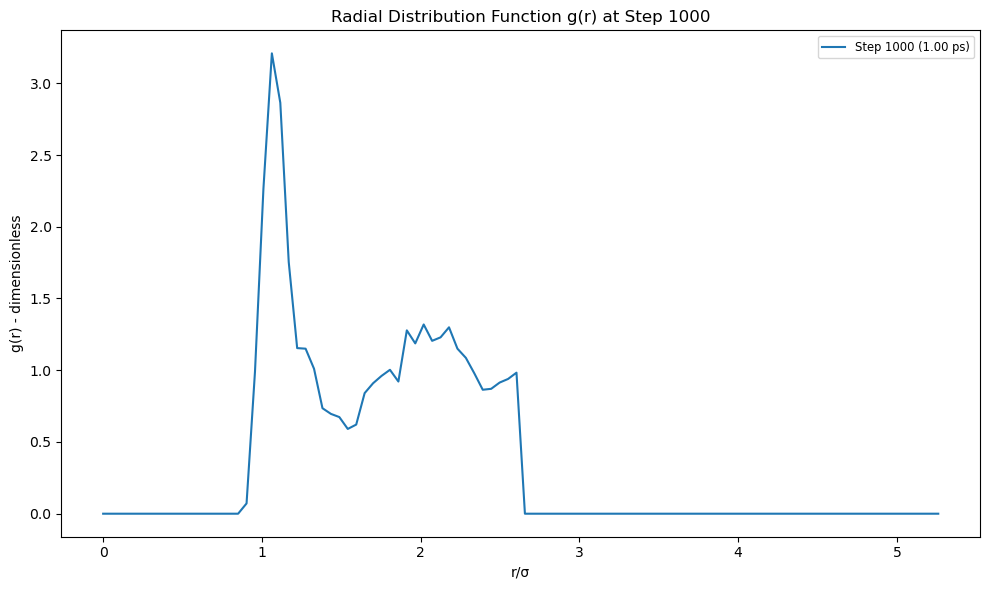

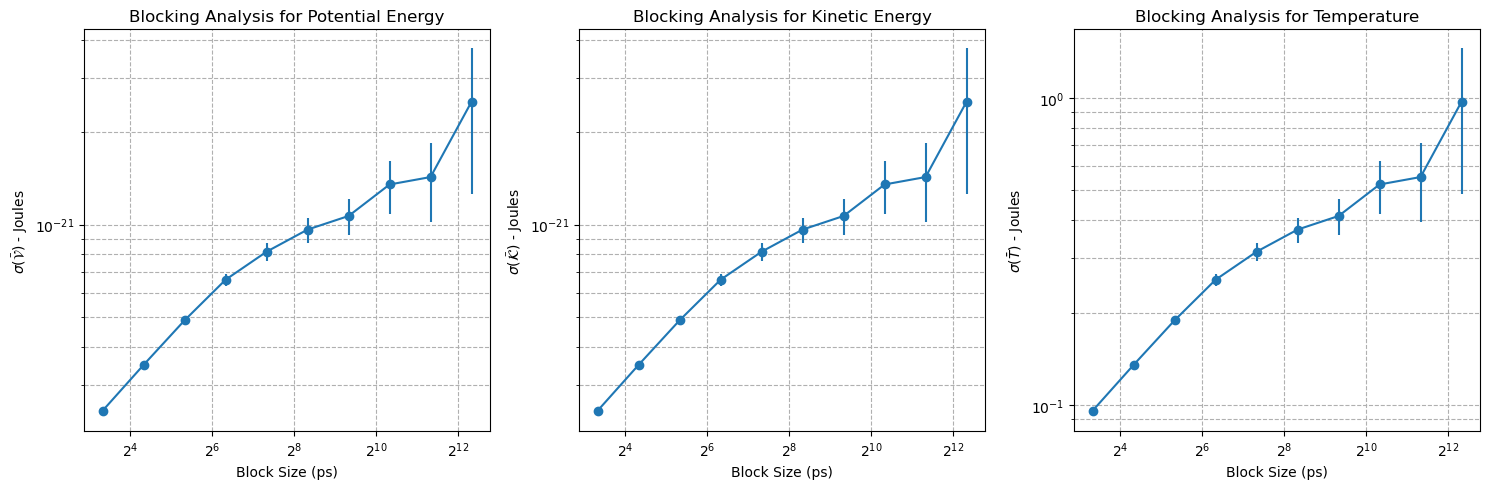

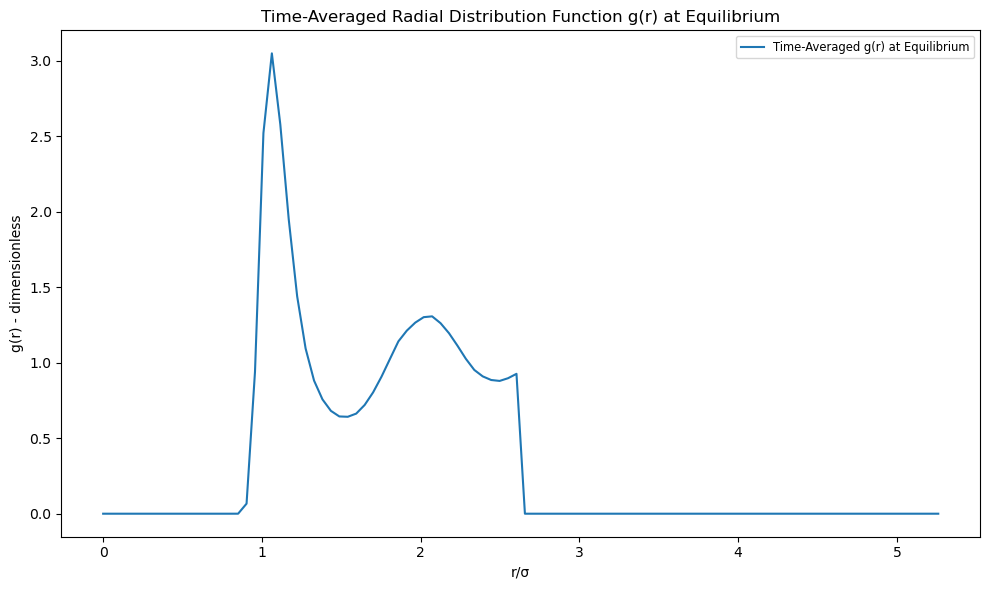

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from uncertainties import ufloat
from uncertainties import unumpy as unp

# Some constants for real unit conversion (Argon)
kB = 1.380649e-23  # J/K
SIGMA = 3.405  # Angstroms
EPSILON = 1.654e-21  # Joules (119.8K*kB)
AVOGADROS = 6.02214076e23 # mol^-1
t_conv = 2.18  # ps (characteristic time for Argon)

# Minimum image convention for PBC:s
@njit
def minimum_image(r_vec, L):
    return r_vec-L*np.rint(r_vec/L)


# Apply Periodic Boundary Conditions
@njit
def apply_PBC(x, L):
    return x-L*np.floor(x/L)   # So we can keep the values within [0, L)


# Generate initial positions for n^3 atoms in a cubic lattice
@njit
def generate_lattice(n, L):
    d = L/n  # spacing
    positions = []
    for i in range(n):
        for j in range(n):
            for k in range(n):
                x = i*d
                y = j*d
                z = k*d
                positions.append([x, y, z])
    return np.array(positions)


# Generate random velocities for the initial velocities with a normal distrinution
@njit
def random_velocities(N, temperature):
    np.random.seed(42)
    v = np.random.randn(N, 3)  # normal distribution
    K = 0.5*np.sum(v**2)
    # Rescale velocities 
    v = rescale_velocities(v, N, K, temperature)
    # Remove center of mass velocity
    v_center_of_mass = np.sum(v, axis=0)/N  
    v -= v_center_of_mass
    return v


# Function to rescale the velocities to the target temperature
@njit
def rescale_velocities(v, N, K, target_temperature):
    current_temperature = (2/3)*(K/N)
    scaling_factor = np.sqrt(target_temperature/current_temperature)
    return v*scaling_factor

# Molecular Dynamics function
@njit
def MD(x, v, dt, steps, L, target_temp, n_bins):
    N = x.shape[0]
    x = x.copy()
    v = v.copy()

    F = np.zeros((N, 3), dtype=np.float64) # Initialize forces
    h = np.zeros(n_bins, dtype=np.float64)  # Initialize histogram for RDF
    gs = []  # Store g_r at each time step

    # Preallocate storage arrays
    t_traj = np.zeros(steps)
    x_traj = np.zeros((steps, N, 3))
    v_traj = np.zeros((steps, N, 3))
    V_traj = np.zeros(steps)
    K_traj = np.zeros(steps)
    H_traj = np.zeros(steps)

    for step in range(steps):
        t_traj[step] = step*dt

        # Update position and apply PBC:s
        x += v*dt+0.5*F*dt**2
        x = apply_PBC(x, L) # Wrapping

        # Compute new forces
        F_new = np.zeros((N, 3), dtype=np.float64)
        
        # Compute energies and forces
        V = 0.0
        for i in range(N-1):
            for j in range(i+1, N):
                r_vec = minimum_image(x[i] - x[j], L)
                r2 = np.dot(r_vec, r_vec)
                r = np.sqrt(r2)
                # Computing forces
                F_ij = 4*(12/(r**13)-6/(r**7))*(r_vec/r)
                F_new[i] += F_ij
                F_new[j] -= F_ij
                # Computing energy
                r2i = 1/r2
                r6i = r2i**3
                if r2 > 0:
                    V += 4*(r6i**2-r6i)
                # Compute histogram for RDF
                dr = L/n_bins  # Bin width
                idx = int(r/dr) # Index: to which bin the distance belongs to 
                if r < L/2:  # Ensures r is in a valid range because of PBC:s 
                    idx = int(r/dr)  
                    if idx < n_bins:  
                        h[idx] += 1  # Count pair

        # Update velocities
        v += 0.5*(F+F_new)*dt
        F = F_new

        K = 0.5*np.sum(v**2)
        H = V + K

        # Apply velocity rescaling a few times during the equilibration phase
        if step < 1000 and step % 50 == 0:
            v = rescale_velocities(v, N, K, target_temp)

        # Store values
        x_traj[step] = x
        v_traj[step] = v
        V_traj[step] = V
        K_traj[step] = K
        H_traj[step] = H

        # RDF
        h*= 2/N # Normalize histogram
        r_i = np.arange(0, n_bins)*dr # Distance to bins
        eps = 1e-15
        g_r = (L**3)/(N*4*np.pi*dr)*h/(r_i+eps)**2 #RDF formula
        gs.append(g_r) # Append to a list




    return t_traj, x_traj, v_traj, V_traj, K_traj, H_traj, gs



########### Argon simulation for a target temp of 95 K and a density of 1.4 g/cm^3 #############################

# Calculate box size for target density
mass_atom = 39.948/AVOGADROS # g
density_real = 1.4  # g/cm^3
atoms_density = density_real/mass_atom  # atoms per cm^3

# Run simulation for 125 atoms
n=5
N = n**3
volume_cm3 = N/atoms_density
L_real = (volume_cm3**(1/3))*1e8  # convert cm to Å
L = L_real/SIGMA

# Temperature for simulation
target_temp = 95  # K
T_star = (kB*target_temp)/EPSILON

# Generate initial positions and velocities
x0 = generate_lattice(n, L)
v0 = random_velocities(N, temperature=T_star)


# Run simulation for X ps
total_t_real = 20 # Total time in picoseconds
total_t = total_t_real / t_conv # Total time in reduced units
dt_real = 0.001 # Timestep in picoseconds
dt = dt_real / t_conv # Timestep in reduced units
steps = int(total_t//dt)
print(f"Red units: total time: {total_t}, timestep: {dt}, Steps: {steps}")

t, x, v, V, K, H, gs = MD(x0, v0, dt, steps, L, target_temp=T_star, n_bins=100)

# Convert to real units
t_real = t * t_conv
x_real = x * SIGMA
v_real = v * SIGMA/t_conv
V_real = V * EPSILON
K_real = K * EPSILON
H_real = H * EPSILON

############################################################################################################

#### Study of equilibrium ####:

# Plot energies
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
plt.plot(t_real, V_real, label="Potential Energy V(t)")
plt.plot(t_real, K_real, label="Kinetic Energy K(t)")
plt.plot(t_real, H_real, label="Total Energy H(t)")
plt.axvline(x=1, color='r', linestyle='--', label="Approx. equilibration time ~1 ps")
plt.xlabel("Time (ps)")
plt.ylabel("Energy (J)")
plt.title("Energy Components Analysis Over Time")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(t_real, H_real, label="Hamiltonian H(t)")
plt.axvline(x=1, color='r', linestyle='--', label="Approx. equilibration time ~1 ps")
plt.xlabel("Time (ps)")
plt.ylabel("Energy (J)")
plt.title("Hamiltonian Over Time")
plt.legend()
plt.grid()

# Plot Temperature over time
T_real = (2/3)*(K_real/(N*kB)) # Compute temperature in real units 
plt.figure(figsize=(10, 6))
plt.plot(t_real, T_real, label="Temperature T(t)")
plt.axvline(x=1, color='r', linestyle='--', label="Approx. equilibration time ~1 ps")
plt.xlabel("Time (ps)")
plt.ylabel("Temperature (K)")
plt.title("Temperature Evolution Over Time")
plt.legend()
plt.grid()



##### RDF g(r) ###########:

# Evolution of g(r)
fig, ax = plt.subplots(figsize=(10, 6))
time_steps = range(0, steps, 1000) # Time-steps for plotting
for step in time_steps:
    g_r = gs[step]
    r_i = np.arange(0, len(g_r))*(L/len(g_r))
    ax.plot(r_i, g_r, label=f'Step {step} ({t_real[step]:.2f} ps)' if step % 5 == 0 else '')

ax.set_xlabel('r/σ')
ax.set_ylabel('g(r) - dimensionless')
ax.set_title('Evolution of Radial Distribution Function g(r)')
ax.legend(loc='upper right', fontsize='small', ncol=2)
plt.tight_layout()


# g(r) for specific step:
specific_step = 1000
g_r = gs[specific_step]
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(r_i, g_r, label=f'Step {specific_step} ({t_real[specific_step]:.2f} ps)')
ax.set_xlabel('r/σ')
ax.set_ylabel('g(r) - dimensionless')
ax.set_title(f'Radial Distribution Function g(r) at Step {specific_step}')
ax.legend(loc='upper right', fontsize='small', ncol=1)
plt.tight_layout()


##### Error Analysis after equilibrium ######:

def blocking_analysis(data):
    N = len(data)
    dblock = 2  # Each block size doubles
    block_sizes = []
    errors = []
    error_bars = []
    block_size = 10
    while block_size <= N // 2:
        num_blocks = N // block_size # n_b=n/k in compendium
        Ak_i=[]  #A^k_i compendium
        for i in range(num_blocks):

            block = data[i * block_size: (i + 1) * block_size]  # Select block
            Ak_i.append(np.mean(block))  # Compute mean of block


        mean_data = np.mean(data)  # Average of A
        variance = (1/num_blocks)*np.sum((np.array(Ak_i) - mean_data) ** 2)  # Equation 6 in compendium
        standard_error = np.sqrt(variance / (num_blocks - 1))  # Equation 8 in compendium
        error_bar = standard_error*ufloat(1, 1/np.sqrt(2*(num_blocks-1)))  # Equation 11 in compendium
    
        
        block_sizes.append(block_size)
        errors.append(standard_error)
        error_bars.append(error_bar)

        block_size *= dblock  # Double the block size

    return np.array(block_sizes), np.array(errors), np.array(error_bars)



# Extract equilibrium data
equilibrium_steps = range(1000, steps)  # Adjust based on your equilibration point
V_eq = V_real[equilibrium_steps]
K_eq = K_real[equilibrium_steps]
T_eq = T_real[equilibrium_steps]
# Averages for V, K and T
average_V = np.mean(V_eq)  
average_K = np.mean(K_eq)  
average_T = np.mean(T_eq)  


# Perform blocking analysis for each property
block_sizes_V, std_errors_V, error_bars_V = blocking_analysis(V_eq)
block_sizes_K, std_errors_K, error_bars_K = blocking_analysis(K_eq)
block_sizes_T, std_errors_T, error_bars_T = blocking_analysis(T_eq)

# Convert ufloat arrays to nominal values and standard deviations
std_errors_V_nom = unp.nominal_values(error_bars_V)
std_errors_V_err = unp.std_devs(error_bars_V)

std_errors_K_nom = unp.nominal_values(error_bars_K)
std_errors_K_err = unp.std_devs(error_bars_K)

std_errors_T_nom = unp.nominal_values(error_bars_T)
std_errors_T_err = unp.std_devs(error_bars_T)

# Plot blocking with error bars
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.errorbar(block_sizes_V, std_errors_V_nom, yerr=std_errors_V_err, fmt='o-')
plt.xlabel("Block Size (ps)")
plt.ylabel(r'$\sigma(\mathcal{\bar{V}})$'" - Joules")
plt.title("Blocking Analysis for Potential Energy")
plt.xscale("log", base=2)
plt.yscale("log")
plt.grid(True, which="both", linestyle="--")
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.errorbar(block_sizes_K, std_errors_K_nom, yerr=std_errors_K_err, fmt='o-')
plt.xlabel("Block Size (ps)")
plt.ylabel(r'$\sigma(\mathcal{\bar{K}})$'" - Joules")
plt.title("Blocking Analysis for Kinetic Energy")
plt.xscale("log", base=2)
plt.yscale("log")
plt.grid(True, which="both", linestyle="--")
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.errorbar(block_sizes_T, std_errors_T_nom, yerr=std_errors_T_err, fmt='o-')
plt.xlabel("Block Size (ps)")
plt.ylabel(r'$\sigma(\bar{T})$'" - Joules")
plt.title("Blocking Analysis for Temperature")
plt.xscale("log", base=2)
plt.yscale("log")
plt.grid(True, which="both", linestyle="--")
plt.tight_layout()

print("Block sizes for V:", block_sizes_V)
print("Block sizes for K:", block_sizes_K)
print("Block sizes for T:", block_sizes_T)


# Find the index of block size: 1280 since more or less where plateau starts
plateau_index_V = np.where(block_sizes_V == 1280)[0][0]
plateau_index_K = np.where(block_sizes_K == 1280)[0][0]
plateau_index_T = np.where(block_sizes_T == 1280)[0][0]

# Extract standard errors at plateau
error_V = std_errors_V_nom[plateau_index_V]
error_K = std_errors_K_nom[plateau_index_K]
error_T = std_errors_T_nom[plateau_index_T]

# Create ufloat values for reporting
V_report = ufloat(average_V, error_V)
K_report = ufloat(average_K, error_K)
T_report = ufloat(average_T, error_T)

# Compute specific heat capacity c_V
k = K_real[equilibrium_steps]/N # k (kinetic energy per atom)
sigma2_k = np.mean((k-np.mean(k))**2) 
c_V = ((2/(3*kB))-((4*N*sigma2_k)/(9*(kB**3)*(average_T**2))))**-1
c_V*=AVOGADROS # mol-1 

# Report calculations with errors
print(f"Average Potential Energy (V): {V_report:.2uP} J")
print(f"Average Kinetic Energy (K): {K_report:.2uP} J")
print(f"Average Temperature (T): {T_report:.2uP} K")
print(f"Chosen Block Size: 320")

# Report calculations
print(f"Average Potential Energy (V): {average_V} J")
print(f"Average Kinetic Energy (K): {average_K} J")
print(f"Average Temperature (T): {average_T} K")
print(f"Specific Heat Capacity (c_V): {c_V} J/K/mol")

# Plot Time-averaged g(r) at equilibrium
g_r_avg = np.mean([gs[step] for step in equilibrium_steps], axis=0)
r_i = np.arange(0, len(g_r_avg))*(L/len(g_r_avg))
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(r_i, g_r_avg, label='Time-Averaged g(r) at Equilibrium')
ax.set_xlabel('r/σ')
ax.set_ylabel('g(r) - dimensionless')
ax.set_title('Time-Averaged Radial Distribution Function g(r) at Equilibrium')
ax.legend(loc='upper right', fontsize='small', ncol=1)
plt.tight_layout()


plt.show()